In [87]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from torchvision import datasets, transforms
from torch.utils.data import ConcatDataset, Subset, TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [88]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("oddrationale/mnist-in-csv")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'mnist-in-csv' dataset.
Path to dataset files: /kaggle/input/mnist-in-csv


load dataset

In [89]:
train_df = pd.read_csv(f'{path}/mnist_train.csv') # data in csv is already flattened
test_df = pd.read_csv(f'{path}/mnist_test.csv')
y_train = train_df['label'].values
x_train = train_df.drop(columns=['label']).values
y_test = test_df['label'].values
x_test = test_df.drop(columns=['label']).values
#  combine into one dataset to have our own splits
x = np.concatenate((x_train, x_test), axis=0)
y = np.concatenate((y_train, y_test), axis=0)


normalize pixel values

In [90]:
x_norm = x.astype("float32") / 255.0
print(f"Original min value: {x.min()}, Original max value: {x.max()}")
print(f"Normalized min value: {x_norm.min()}, Normalized max value: {x_norm.max()}")
print(f"Range of labeles [{y.min()} , {y.max()}]")

Original min value: 0, Original max value: 255
Normalized min value: 0.0, Normalized max value: 1.0
Range of labeles [0 , 9]


create tensors

In [91]:
def create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test, batch_size):
  # we use torch.long for pytorch's loss function
  x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
  y_train_tensor = torch.tensor(y_train, dtype=torch.long)

  x_val_tensor = torch.tensor(x_val, dtype=torch.float32)
  y_val_tensor = torch.tensor(y_val, dtype=torch.long)

  x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
  y_test_tensor = torch.tensor(y_test, dtype=torch.long)

  # zip tenosrs togeather into datasets
  train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
  val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
  test_dataset = TensorDataset(x_test_tensor, y_test_tensor)

  # create dataloaders
  train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
  val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
  test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
  return train_dataloader, val_dataloader, test_dataloader

### Utility functions

In [92]:
def sigmoid(z):
    return 1.0 / (1.0 + torch.exp(-z))

def binary_cross_entropy_loss(y_pred, y_true):
    epsilon = 1e-8
    loss = -(y_true * torch.log(y_pred + epsilon) + (1 - y_true) * torch.log(1 - y_pred + epsilon)) # epsilon to avoid log(0)

    # Return the average loss over the batch (cost)
    return torch.mean(loss)
def softmax(logits):
    # Subtract max for numerical stability (prevents overflow)
    exp_logits = torch.exp(logits - torch.max(logits, dim=1, keepdim=True).values)
    return exp_logits / torch.sum(exp_logits, dim=1, keepdim=True)

def cross_entropy_loss(softmax_probs, y_true):
    # y_true is shape [N], e.g., [7, 2, 1, ...]
    # We need to pick the probabilities corresponding to the true class
    num_samples = y_true.shape[0]

    epsilon = 1e-8
    log_probs = torch.log(softmax_probs + epsilon) # Add epsilon for stability

    # y_true.view(-1, 1) makes it a column vector for gather
    correct_log_probs = log_probs.gather(1, y_true.view(-1, 1)) # treats y_true as index of target class

    loss = -torch.mean(correct_log_probs)
    return loss # cost

## Logistic regression

Filter dataset to include only 0s and 1s

In [93]:
filter_mask = (y == 0) | (y == 1)
print(f"Total 0s and 1s in dataset: {np.sum(filter_mask)}")

x_binary = x_norm[filter_mask]
y_binary = y[filter_mask]

Total 0s and 1s in dataset: 14780


split dataset

In [94]:
binary_x_train, binary_x_temp, binary_y_train, binary_y_temp = train_test_split(x_binary, y_binary, train_size=0.60, random_state=42)
binary_x_val, binary_x_test, binary_y_val, binary_y_test = train_test_split(binary_x_temp, binary_y_temp, train_size=0.50, random_state=42)

print(f"Training set shape:   {binary_x_train.shape} | {binary_y_train.shape}")
print(f"Validation set shape: {binary_x_val.shape} | {binary_y_val.shape}")
print(f"Test set shape:       {binary_x_test.shape} | {binary_y_test .shape}")

Training set shape:   (8868, 784) | (8868,)
Validation set shape: (2956, 784) | (2956,)
Test set shape:       (2956, 784) | (2956,)


training loop

In [95]:
def binary_train(hyperparameters, show_progress, binary_train_dataloader, binary_val_dataloader):
  # Set hyperparameters
  learning_rate = hyperparameters[0]
  batch_size = hyperparameters[1]
  num_epochs = hyperparameters[2]

  num_features = x_train.shape[1]
  num_outputs = 1 # [ 0, 1]

  # Initialize weights randomly and bias at zero
  w = torch.randn(num_features, num_outputs, requires_grad=True)  # set as requires_grad so torch computes their gradients
  b = torch.zeros(num_outputs, requires_grad=True)

  print(f"Learning rate: {learning_rate}\nBatch size: {batch_size}\nEpochs: {num_epochs}")
  print("Starting training...")
  binary_train_loss_history = []
  binary_val_loss_history = []
  binary_train_acc_history = []
  binary_val_acc_history = []
  for epoch in range(num_epochs):
      train_loss = 0.0
      train_correct = 0
      train_total = 0
      for images, labels in binary_train_dataloader:
        # images is [64, 784] and labels is [64]
        # reshape labels to [64,1]
        labels = labels.view(-1, 1)
        logits = torch.matmul(images, w) + b # z
        y_pred = sigmoid(logits) # y
        loss = binary_cross_entropy_loss(y_pred, labels) # J
        train_loss += loss.item() # accumlate the loss of each batch
        predicted = (y_pred > 0.5).float()
        train_total += labels.size(0)
        train_correct += (predicted == labels).sum().item()
        # clear old gradients
        if w.grad is not None:
              w.grad.zero_()
        if b.grad is not None:
              b.grad.zero_()
        # compute new gradients dj/dw and dj/db
        loss.backward()
        with torch.no_grad(): # this prevents this part from affecting gradient calculations
          w -= learning_rate * w.grad
          b -= learning_rate * b.grad

      # validation phase
      val_loss = 0.0
      val_correct = 0
      val_total = 0

      with torch.no_grad(): # Turn off gradients for validation
          for images, labels in binary_val_dataloader:
              labels = labels.view(-1, 1)

              # Forward pass
              logits = torch.matmul(images, w) + b
              y_pred = sigmoid(logits)

              # Calculate validation loss
              val_loss += binary_cross_entropy_loss(y_pred, labels).item()

              # Calculate accuracy
              predicted = (y_pred > 0.5).float()
              val_total += labels.size(0)
              val_correct += (predicted == labels).sum().item()

      avg_train_loss = train_loss / len(binary_train_dataloader)
      train_accuracy = 100 * train_correct / train_total
      avg_val_loss = val_loss / len(binary_val_dataloader)
      val_accuracy = 100 * val_correct / val_total

      if show_progress:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {avg_val_loss:.4f}, "
              f"Val Accuracy: {val_accuracy:.2f}% "
              f"Train Accuracy: {train_accuracy:.2f}%")
      binary_train_loss_history.append(avg_train_loss)
      binary_val_loss_history.append(avg_val_loss)
      binary_train_acc_history.append(train_accuracy)
      binary_val_acc_history.append(val_accuracy)


  print("Training finished.")

  # Plotting the results
  epochs_range = range(1, num_epochs + 1)

  plt.figure(figsize=(6, 4))

  # Plot Loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, binary_train_loss_history, 'b-', label='Training Loss')
  plt.plot(epochs_range, binary_val_loss_history, 'r-', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Plot Accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, binary_train_acc_history, 'b-', label='Training Accuracy')
  plt.plot(epochs_range, binary_val_acc_history, 'r-', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy (%)')
  plt.legend()

  plt.tight_layout()
  plt.show()
  return w, b # return best weights

In [96]:
def binary_test(binary_w, binary_b, binary_test_dataloader):
  all_labels_list = []
  all_predicted_list = []
  correct = 0
  total = 0
  with torch.no_grad():
      for images, labels in binary_test_dataloader:
          labels = labels.view(-1, 1)
          logits = torch.matmul(images, binary_w) + binary_b
          y_pred = sigmoid(logits)
          predicted = (y_pred > 0.5).float()
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
          all_labels_list.append(labels.numpy())
          all_predicted_list.append(predicted.numpy())

  print(f"\nFinal Test Accuracy: {100 * correct / total:.2f}%")
  all_labels = np.concatenate(all_labels_list)
  all_predicted = np.concatenate(all_predicted_list)
  cm = confusion_matrix(all_labels, all_predicted)

  class_names = ['Digit 0', 'Digit 1']
  plt.figure(figsize=(6, 2))

  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=class_names,
              yticklabels=class_names)
  plt.title('Confusion Matrix')
  plt.ylabel('Actual Label')
  plt.xlabel('Predicted Label')
  plt.show()

Learning rate: 0.01
Batch size: 32
Epochs: 20
Starting training...
Epoch [1/20], Train Loss: 1.0146, Val Loss: 0.3294, Val Accuracy: 89.58% Train Accuracy: 73.46%
Epoch [2/20], Train Loss: 0.2571, Val Loss: 0.1649, Val Accuracy: 94.38% Train Accuracy: 91.95%
Epoch [3/20], Train Loss: 0.1521, Val Loss: 0.1136, Val Accuracy: 96.45% Train Accuracy: 95.40%
Epoch [4/20], Train Loss: 0.1087, Val Loss: 0.0892, Val Accuracy: 97.36% Train Accuracy: 96.65%
Epoch [5/20], Train Loss: 0.0865, Val Loss: 0.0746, Val Accuracy: 97.87% Train Accuracy: 97.43%
Epoch [6/20], Train Loss: 0.0734, Val Loss: 0.0647, Val Accuracy: 98.11% Train Accuracy: 97.82%
Epoch [7/20], Train Loss: 0.0639, Val Loss: 0.0575, Val Accuracy: 98.34% Train Accuracy: 98.14%
Epoch [8/20], Train Loss: 0.0562, Val Loss: 0.0521, Val Accuracy: 98.44% Train Accuracy: 98.35%
Epoch [9/20], Train Loss: 0.0508, Val Loss: 0.0477, Val Accuracy: 98.51% Train Accuracy: 98.50%
Epoch [10/20], Train Loss: 0.0466, Val Loss: 0.0442, Val Accuracy: 98

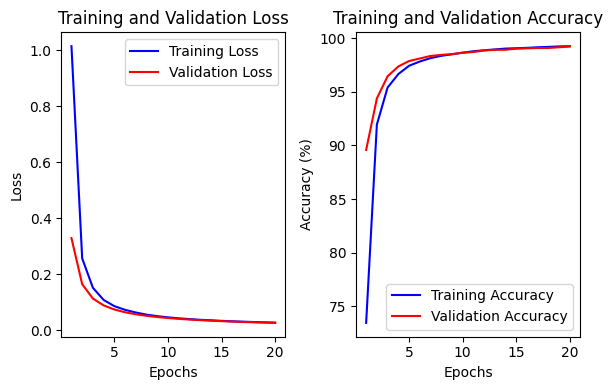

In [97]:
binary_train_dataloader, binary_val_dataloader, binary_test_dataloader = create_tensors_loaders(
  binary_x_train, binary_y_train,
  binary_x_val, binary_y_val,
  binary_x_test, binary_y_test, 32)
hyperparameters = [0.01, 32, 20]
binary_w, binary_b = binary_train(hyperparameters, show_progress=True, binary_train_dataloader=binary_train_dataloader , binary_val_dataloader=binary_val_dataloader) # best weights


testing


Final Test Accuracy: 99.29%


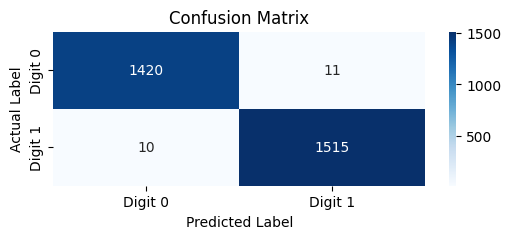

In [98]:
binary_test(binary_w, binary_b, binary_test_dataloader=binary_test_dataloader)

## softmax regression

In [99]:
x_train, x_temp, y_train, y_temp = train_test_split(x_norm, y, train_size=0.60, random_state=42, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, train_size=0.50, random_state=42, stratify = y_temp) # Ensure stratification on y_temp

print(f"Training set shape:   {x_train.shape} | {y_train.shape}")
print(f"Validation set shape: {x_val.shape} | {y_val.shape}")
print(f"Test set shape:       {x_test.shape} | {y_test .shape}")

Training set shape:   (42000, 784) | (42000,)
Validation set shape: (14000, 784) | (14000,)
Test set shape:       (14000, 784) | (14000,)


In [100]:
def multi_train(hyperparameters, show_progress, train_dataloader, val_dataloader):
  # Set hyperparameters
  learning_rate = hyperparameters[0]
  batch_size = hyperparameters[1]
  num_epochs = hyperparameters[2]

  num_features = 784
  num_outputs = 10

  # Initialize weights randomly and bias at zero
  w = torch.randn(num_features, num_outputs) * 0.01  # mult by 0.01 to lower weights
  w.requires_grad = True
  b = torch.zeros(num_outputs, requires_grad=True)

  # train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(
  #     x_train, y_train,
  #     x_val, y_val,
  #     x_test, y_test, batch_size)

  print(f"Learning rate: {learning_rate}\nBatch size: {batch_size}\nEpochs: {num_epochs}")
  print("starting training...")
  train_loss_history = []
  val_loss_history = []
  train_acc_history = []
  val_acc_history = []
  for epoch in range(num_epochs):
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    #  training phase
    for images, labels in train_dataloader:

      logits = torch.matmul(images, w) + b # z
      y_pred = softmax(logits) # y
      loss = cross_entropy_loss(y_pred, labels) # J
      train_loss += loss.item() # accumlate the loss of each batch

      predicted_class = torch.argmax(y_pred, dim=1) # predict based on largest probability
      train_total += labels.size(0)
      train_correct += (predicted_class == labels).sum().item()

      # clear old gradients
      if w.grad is not None:
            w.grad.zero_()
      if b.grad is not None:
            b.grad.zero_()
      # compute new gradients dj/dw and dj/db
      loss.backward()
      with torch.no_grad(): # this prevents this part from affecting gradient calculations
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad
    # Validation phase
    val_loss = 0.0 # Reset val_loss at the start of validation
    val_correct = 0 # Reset val_correct
    val_total = 0 # Reset val_total
    with torch.no_grad(): # Turn off gradients for validation
          for images, labels in val_dataloader:

              logits = torch.matmul(images, w) + b
              y_pred = softmax(logits)

              val_loss += cross_entropy_loss(y_pred, labels).item()

              # Calculate accuracy
              predicted_class = torch.argmax(y_pred, dim=1) # predict based on largest probability
              val_total += labels.size(0)
              val_correct += (predicted_class == labels).sum().item()

    avg_train_loss = train_loss / len(train_dataloader)
    train_accuracy = 100 * train_correct / train_total
    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = 100 * val_correct / val_total

    if show_progress:
      print(f"Epoch [{epoch+1}/{num_epochs}], "
            f"Train Loss: {avg_train_loss:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, "
            f"Val Accuracy: {val_accuracy:.2f}% "
            f"Train Accuracy: {train_accuracy:.2f}%")
    train_loss_history.append(avg_train_loss)
    val_loss_history.append(avg_val_loss)
    train_acc_history.append(train_accuracy)
    val_acc_history.append(val_accuracy)


  print("Training finished.")

  # Plotting the results
  epochs_range = range(1, num_epochs + 1)

  plt.figure(figsize=(6, 4))

  # Plot Loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_loss_history, 'b-', label='Training Loss')
  plt.plot(epochs_range, val_loss_history, 'r-', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Plot Accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, train_acc_history, 'b-', label='Training Accuracy')
  plt.plot(epochs_range, val_acc_history, 'r-', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy (%)')
  plt.legend()

  plt.tight_layout()
  plt.show()

  return w, b # return best weights

In [101]:
def multi_test(w, b, test_dataloader):
  all_labels_list = []
  all_predicted_list = []
  correct = 0
  total = 0
  with torch.no_grad():
      for images, labels in test_dataloader:
          logits = torch.matmul(images, w) + b

          y_pred = softmax(logits)
          predicted_class = torch.argmax(y_pred, dim=1) # predict based on largest probability
          total += labels.size(0)
          correct += (predicted_class == labels).sum().item()
          all_labels_list.append(labels.numpy())
          all_predicted_list.append(predicted_class.numpy())

  print(f"\nFinal Test Accuracy: {100 * correct / total:.2f}%")
  all_labels = np.concatenate(all_labels_list)
  all_predicted = np.concatenate(all_predicted_list)
  cm = confusion_matrix(all_labels, all_predicted)

  class_names = [str(i) for i in range(10)] # all digits
  plt.figure(figsize=(6, 4))

  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=class_names,
              yticklabels=class_names)
  plt.title('Confusion Matrix')
  plt.ylabel('Actual Label')
  plt.xlabel('Predicted Label')
  plt.show()

Learning rate: 0.01
Batch size: 64
Epochs: 20
starting training...
Training finished.


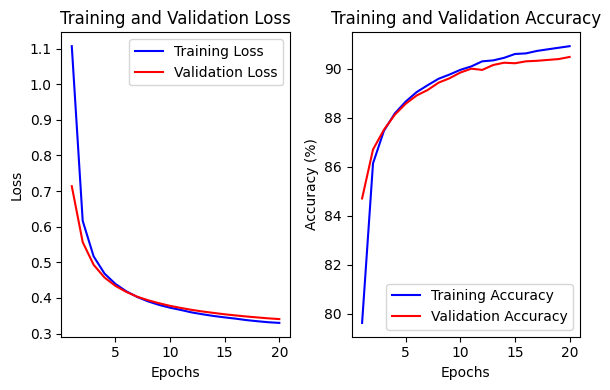

In [102]:
train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,64)
hyperparameters = [0.01, 64, 20]
w, b = multi_train(hyperparameters, show_progress=False, train_dataloader=train_dataloader, val_dataloader=val_dataloader) # best weights


Final Test Accuracy: 90.58%


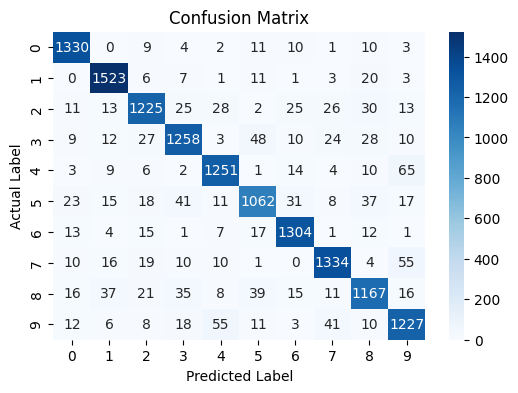

In [103]:
multi_test(w, b, test_dataloader)

pytorch builtin

In [104]:
x_train, x_temp, y_train, y_temp = train_test_split(x_norm, y, train_size=0.60, random_state=42, stratify=y)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, train_size=0.50, random_state=42, stratify = y_temp)

print(f"Training set shape:   {x_train.shape} | {y_train.shape}")
print(f"Validation set shape: {x_val.shape} | {y_val.shape}")
print(f"Test set shape:       {x_test.shape} | {y_test .shape}")

Training set shape:   (42000, 784) | (42000,)
Validation set shape: (14000, 784) | (14000,)
Test set shape:       (14000, 784) | (14000,)


In [105]:
class BuiltInSoftmaxModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(784, 10)

    def forward(self, x):
        # Return raw logits, as nn.CrossEntropyLoss expects them
        return self.linear(x)

model_builtin = BuiltInSoftmaxModel()

criterion = nn.CrossEntropyLoss()

# Re-create dataloaders using the full dataset (all 10 digits)
train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(
    x_train, y_train,
    x_val, y_val,
    x_test, y_test, 64)


In [106]:
def torch_train(model_builtin, hyperparameters, show_progress, train_dataloader, val_dataloader):

  learning_rate = hyperparameters[0]
  batch_size = hyperparameters[1]
  num_epochs = hyperparameters[2]

  train_loss_hist_builtin = []
  val_loss_hist_builtin = []
  train_acc_hist_builtin = []
  val_acc_hist_builtin = []

  optimizer = torch.optim.SGD(model_builtin.parameters(), lr=learning_rate)

  print(f"Learning rate: {learning_rate}\nBatch size: {batch_size}\nEpochs: {num_epochs}")
  print("Starting built-in pytorch training for verification...")
  for epoch in range(num_epochs):
      train_loss = 0.0
      train_correct = 0
      train_total = 0

      for images, labels in train_dataloader:

          logits = model_builtin(images)
          loss = criterion(logits, labels) # So much simpler!
          train_loss += loss.item()

          # training accuracy calculation ---
          predicted_class = torch.argmax(logits, dim=1)
          train_total += labels.size(0)
          train_correct += (predicted_class == labels).sum().item()
          # -----------------------------------------

          optimizer.zero_grad() # Clears gradients for all parameters
          loss.backward()

          optimizer.step() # Updates all parameters (w and b)

      # Validation Phase
      val_loss = 0.0
      val_correct = 0
      val_total = 0
      with torch.no_grad():
          for images, labels in val_dataloader:
              logits = model_builtin(images)
              val_loss += criterion(logits, labels).item()

              predicted_class = torch.argmax(logits, dim=1) # Argmax on logits is fine
              val_total += labels.size(0)
              val_correct += (predicted_class == labels).sum().item()

      # Calculate and store all metrics
      avg_train_loss = train_loss / len(train_dataloader)
      train_accuracy = 100 * train_correct / train_total
      avg_val_loss = val_loss / len(val_dataloader)
      val_accuracy = 100 * val_correct / val_total

      train_loss_hist_builtin.append(avg_train_loss)
      val_loss_hist_builtin.append(avg_val_loss)
      train_acc_hist_builtin.append(train_accuracy)
      val_acc_hist_builtin.append(val_accuracy)

      if show_progress:
        print(f"Epoch [{epoch+1}/{num_epochs}], "
            f"Train Loss: {avg_train_loss:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, "
            f"Val Accuracy: {val_accuracy:.2f}% "
            f"Train Accuracy: {train_accuracy:.2f}%")


  print("Built-in pytorch training finished.")

  epochs_range = range(1, num_epochs + 1)

  plt.figure(figsize=(6, 4))

  # Plot Loss
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_loss_hist_builtin, 'b-', label='Training Loss')
  plt.plot(epochs_range, val_loss_hist_builtin, 'r-', label='Validation Loss')
  plt.title('Training and Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  # Plot Accuracy
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, train_acc_hist_builtin, 'b-', label='Training Accuracy')
  plt.plot(epochs_range, val_acc_hist_builtin, 'r-', label='Validation Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy (%)')
  plt.legend()

  plt.tight_layout()
  plt.show()

In [107]:
def torch_test(model_builtin, test_dataloader):
  all_labels_list = []
  all_predicted_list = []
  correct = 0
  total = 0
  with torch.no_grad():
      for images, labels in test_dataloader:
          logits = model_builtin(images)

          predicted_class = torch.argmax(logits, dim=1) # Argmax on logits is fine
          total += labels.size(0)
          correct += (predicted_class == labels).sum().item()
          all_labels_list.append(labels.numpy())
          all_predicted_list.append(predicted_class.numpy())

  print(f"\nFinal Test Accuracy: {100 * correct / total:.2f}%")
  all_labels = np.concatenate(all_labels_list)
  all_predicted = np.concatenate(all_predicted_list)
  cm = confusion_matrix(all_labels, all_predicted)

  class_names = [str(i) for i in range(10)] # all digits
  plt.figure(figsize=(6, 4)) # Adjusted figure size

  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
              xticklabels=class_names,
              yticklabels=class_names)
  plt.title('Confusion Matrix')
  plt.ylabel('Actual Label')
  plt.xlabel('Predicted Label')
  plt.show()

Learning rate: 0.01
Batch size: 64
Epochs: 20
Starting built-in pytorch training for verification...
Epoch [1/20], Train Loss: 1.0976, Val Loss: 0.7118, Val Accuracy: 84.93% Train Accuracy: 78.79%
Epoch [2/20], Train Loss: 0.6157, Val Loss: 0.5559, Val Accuracy: 86.73% Train Accuracy: 86.03%
Epoch [3/20], Train Loss: 0.5167, Val Loss: 0.4930, Val Accuracy: 87.51% Train Accuracy: 87.36%
Epoch [4/20], Train Loss: 0.4684, Val Loss: 0.4569, Val Accuracy: 88.04% Train Accuracy: 88.10%
Epoch [5/20], Train Loss: 0.4389, Val Loss: 0.4335, Val Accuracy: 88.52% Train Accuracy: 88.65%
Epoch [6/20], Train Loss: 0.4186, Val Loss: 0.4163, Val Accuracy: 88.85% Train Accuracy: 89.05%
Epoch [7/20], Train Loss: 0.4029, Val Loss: 0.4032, Val Accuracy: 89.17% Train Accuracy: 89.33%
Epoch [8/20], Train Loss: 0.3910, Val Loss: 0.3931, Val Accuracy: 89.49% Train Accuracy: 89.52%
Epoch [9/20], Train Loss: 0.3809, Val Loss: 0.3844, Val Accuracy: 89.62% Train Accuracy: 89.75%
Epoch [10/20], Train Loss: 0.3729, 

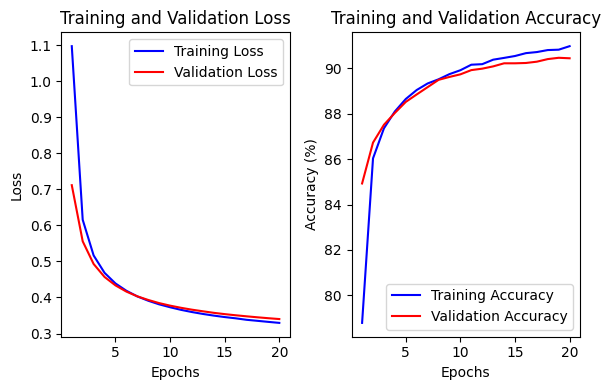

In [108]:
hyperparameters = [0.01, 64, 20]
torch_train(model_builtin, hyperparameters, show_progress=True, train_dataloader=train_dataloader, val_dataloader=val_dataloader)


Final Test Accuracy: 90.54%


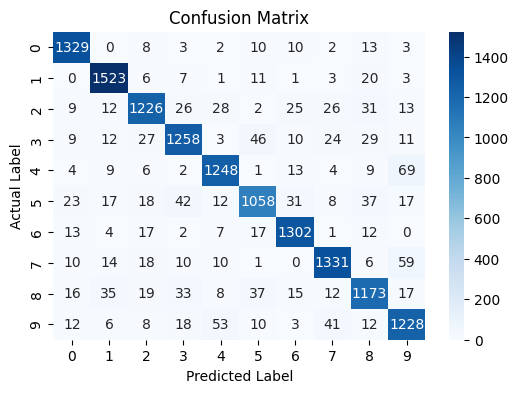

In [109]:
torch_test(model_builtin, test_dataloader)

## analysis

### binary

testing learning rates

In [110]:
hyperparameters1 = [0.001, 32, 20]
hyperparameters2 = [0.01, 32, 20]
hyperparameters3 = [0.1, 32, 20]
hyperparameters4 = [1, 32, 20]

Learning rate: 0.001
Batch size: 32
Epochs: 20
Starting training...
Training finished.


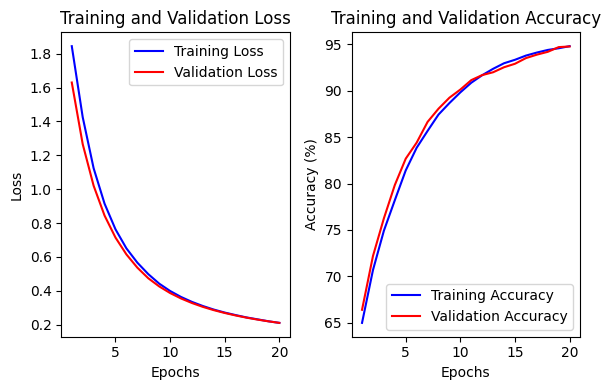

Learning rate: 0.01
Batch size: 32
Epochs: 20
Starting training...
Training finished.


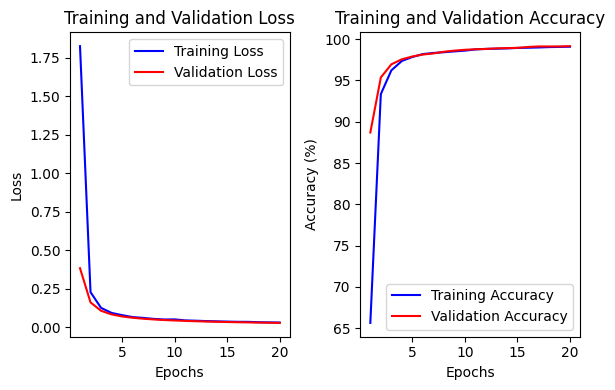

Learning rate: 0.1
Batch size: 32
Epochs: 20
Starting training...
Training finished.


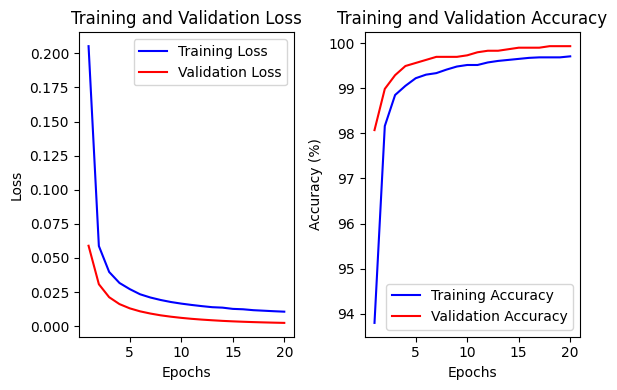

Learning rate: 1
Batch size: 32
Epochs: 20
Starting training...
Training finished.


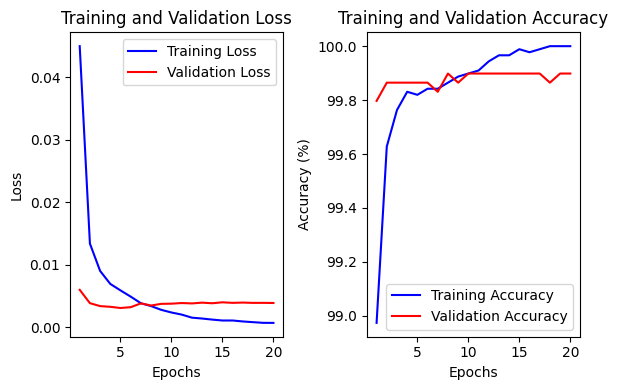

In [111]:
binary_train_dataloader, binary_val_dataloader, binary_test_dataloader = create_tensors_loaders(binary_x_train, binary_y_train,binary_x_val, binary_y_val,binary_x_test, binary_y_test,
hyperparameters1[1])
w1, b1 = binary_train(hyperparameters1, False, binary_train_dataloader, binary_val_dataloader)

binary_train_dataloader, binary_val_dataloader, binary_test_dataloader = create_tensors_loaders(binary_x_train, binary_y_train,binary_x_val, binary_y_val,binary_x_test, binary_y_test,
hyperparameters2[1])
w2, b2 = binary_train(hyperparameters2, False, binary_train_dataloader, binary_val_dataloader)

binary_train_dataloader, binary_val_dataloader, binary_test_dataloader = create_tensors_loaders(binary_x_train, binary_y_train,binary_x_val, binary_y_val,binary_x_test, binary_y_test,
hyperparameters[1])
w3, b3 = binary_train(hyperparameters3, False, binary_train_dataloader, binary_val_dataloader)

binary_train_dataloader, binary_val_dataloader, binary_test_dataloader = create_tensors_loaders(binary_x_train, binary_y_train,binary_x_val, binary_y_val,binary_x_test, binary_y_test,
hyperparameters4[1])
w4, b4 = binary_train(hyperparameters4, False, binary_train_dataloader, binary_val_dataloader)


Final Test Accuracy: 95.03%


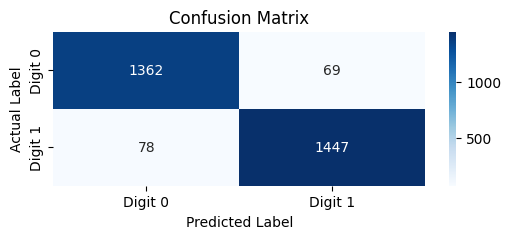


Final Test Accuracy: 99.26%


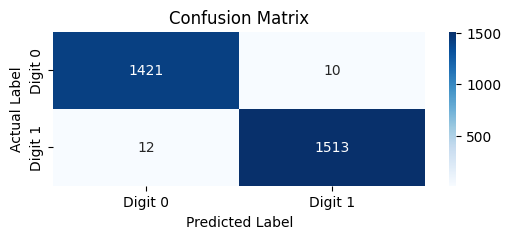


Final Test Accuracy: 99.80%


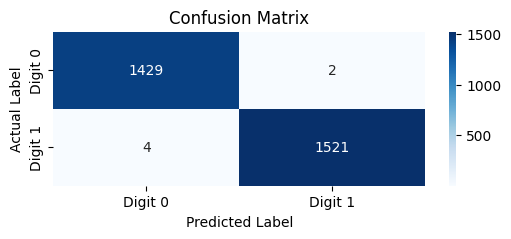


Final Test Accuracy: 99.80%


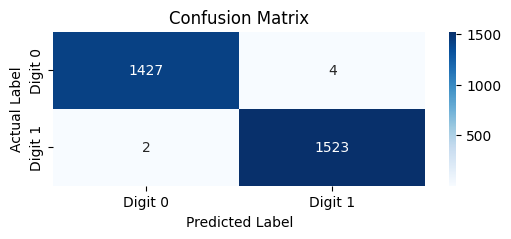

In [112]:
binary_train_dataloader, binary_val_dataloader, binary_test_dataloader = create_tensors_loaders(binary_x_train, binary_y_train,binary_x_val, binary_y_val,binary_x_test, binary_y_test,
hyperparameters1[1])
binary_test(w1, b1, binary_test_dataloader)

binary_train_dataloader, binary_val_dataloader, binary_test_dataloader = create_tensors_loaders(binary_x_train, binary_y_train,binary_x_val, binary_y_val,binary_x_test, binary_y_test,
hyperparameters2[1])
binary_test(w2, b2, binary_test_dataloader)

binary_train_dataloader, binary_val_dataloader, binary_test_dataloader = create_tensors_loaders(binary_x_train, binary_y_train,binary_x_val, binary_y_val,binary_x_test, binary_y_test,
hyperparameters3[1])
binary_test(w3, b3, binary_test_dataloader)

binary_train_dataloader, binary_val_dataloader, binary_test_dataloader = create_tensors_loaders(binary_x_train, binary_y_train,binary_x_val, binary_y_val,binary_x_test, binary_y_test,
hyperparameters4[1])
binary_test(w4, b4, binary_test_dataloader)

testing batch sizes

In [113]:
hyperparameters1 = [0.01, 16, 20]
hyperparameters2 = [0.01, 32, 20]
hyperparameters3 = [0.01, 64, 20]
hyperparameters4 = [0.01, 128, 20]

Learning rate: 0.01
Batch size: 16
Epochs: 20
Starting training...
Training finished.


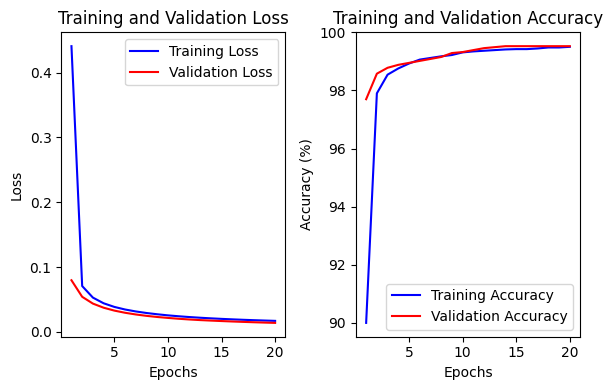

Learning rate: 0.01
Batch size: 32
Epochs: 20
Starting training...
Training finished.


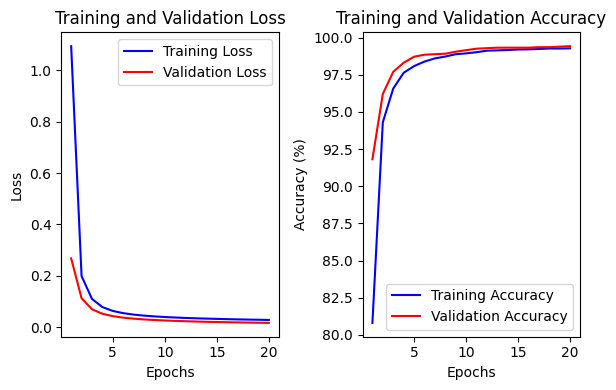

Learning rate: 0.01
Batch size: 64
Epochs: 20
Starting training...
Training finished.


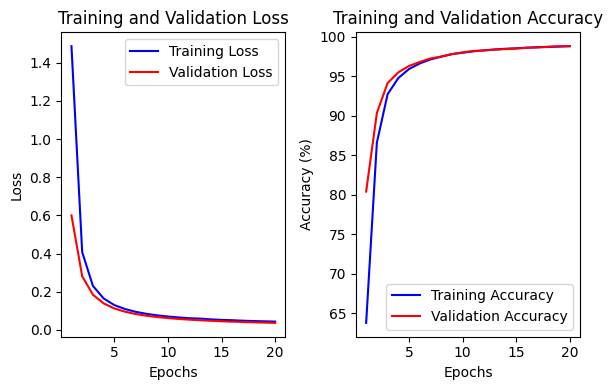

Learning rate: 0.01
Batch size: 128
Epochs: 20
Starting training...
Training finished.


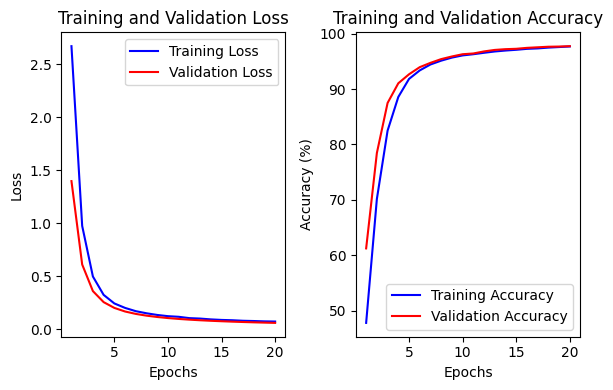

In [114]:
binary_train_dataloader, binary_val_dataloader, binary_test_dataloader = create_tensors_loaders(binary_x_train, binary_y_train,binary_x_val, binary_y_val,binary_x_test, binary_y_test,
hyperparameters1[1])
w1, b1 = binary_train(hyperparameters1, False, binary_train_dataloader, binary_val_dataloader)

binary_train_dataloader, binary_val_dataloader, binary_test_dataloader = create_tensors_loaders(binary_x_train, binary_y_train,binary_x_val, binary_y_val,binary_x_test, binary_y_test,
hyperparameters2[1])
w2, b2 = binary_train(hyperparameters2, False, binary_train_dataloader, binary_val_dataloader)

binary_train_dataloader, binary_val_dataloader, binary_test_dataloader = create_tensors_loaders(binary_x_train, binary_y_train,binary_x_val, binary_y_val,binary_x_test, binary_y_test,
hyperparameters[1])
w3, b3 = binary_train(hyperparameters3, False, binary_train_dataloader, binary_val_dataloader)

binary_train_dataloader, binary_val_dataloader, binary_test_dataloader = create_tensors_loaders(binary_x_train, binary_y_train,binary_x_val, binary_y_val,binary_x_test, binary_y_test,
hyperparameters4[1])
w4, b4 = binary_train(hyperparameters4, False, binary_train_dataloader, binary_val_dataloader)


Final Test Accuracy: 99.56%


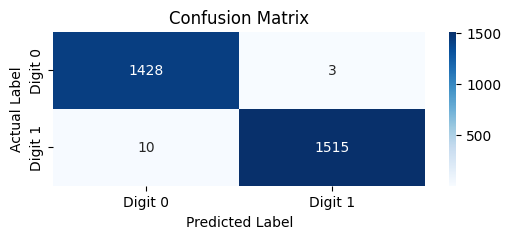


Final Test Accuracy: 99.46%


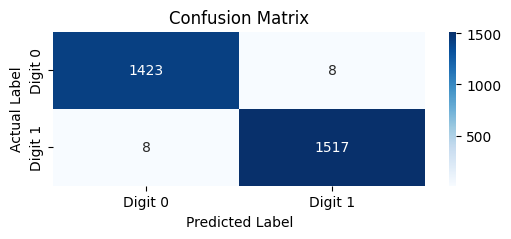


Final Test Accuracy: 98.82%


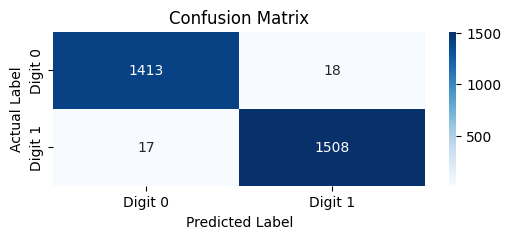


Final Test Accuracy: 98.31%


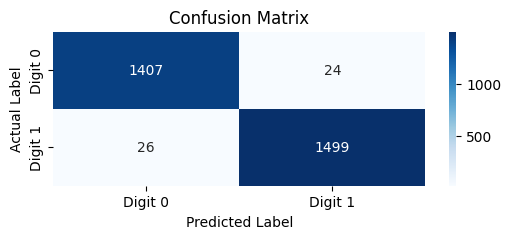

In [115]:
binary_train_dataloader, binary_val_dataloader, binary_test_dataloader = create_tensors_loaders(binary_x_train, binary_y_train,binary_x_val, binary_y_val,binary_x_test, binary_y_test,
hyperparameters1[1])
binary_test(w1, b1, binary_test_dataloader)

binary_train_dataloader, binary_val_dataloader, binary_test_dataloader = create_tensors_loaders(binary_x_train, binary_y_train,binary_x_val, binary_y_val,binary_x_test, binary_y_test,
hyperparameters2[1])
binary_test(w2, b2, binary_test_dataloader)

binary_train_dataloader, binary_val_dataloader, binary_test_dataloader = create_tensors_loaders(binary_x_train, binary_y_train,binary_x_val, binary_y_val,binary_x_test, binary_y_test,
hyperparameters3[1])
binary_test(w3, b3, binary_test_dataloader)

binary_train_dataloader, binary_val_dataloader, binary_test_dataloader = create_tensors_loaders(binary_x_train, binary_y_train,binary_x_val, binary_y_val,binary_x_test, binary_y_test,
hyperparameters4[1])
binary_test(w4, b4, binary_test_dataloader)

### multi

testing learning rates

In [116]:
hyperparameters1 = [0.001, 32, 20]
hyperparameters2 = [0.01, 32, 20]
hyperparameters3 = [0.1, 32, 20]
hyperparameters4 = [1, 32, 20]

Learning rate: 0.001
Batch size: 32
Epochs: 20
starting training...
Training finished.


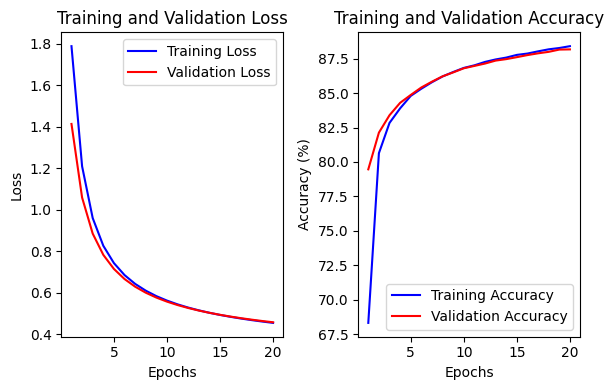

Learning rate: 0.01
Batch size: 32
Epochs: 20
starting training...
Training finished.


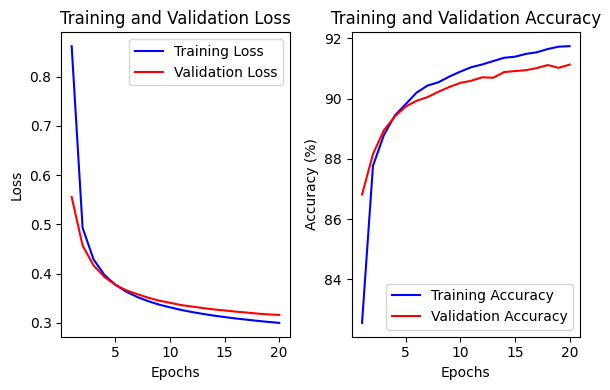

Learning rate: 0.1
Batch size: 32
Epochs: 20
starting training...
Training finished.


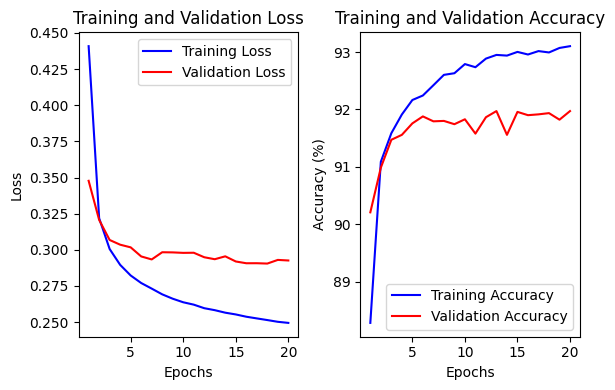

Learning rate: 1
Batch size: 32
Epochs: 20
starting training...
Training finished.


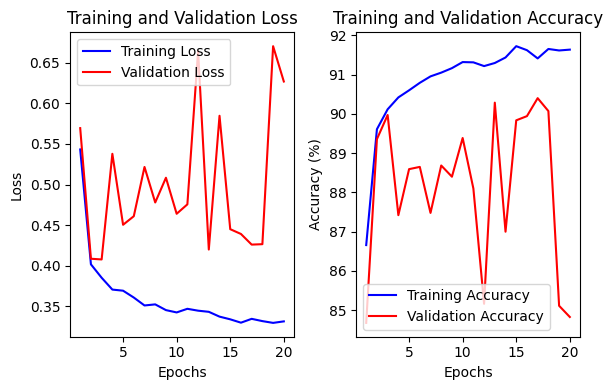

In [117]:
train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters1[1])
w1, b1 = multi_train(hyperparameters1, False, train_dataloader, val_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters2[1])
w2, b2 = multi_train(hyperparameters2, False, train_dataloader, val_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters3[1])
w3, b3 = multi_train(hyperparameters3, False, train_dataloader, val_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters4[1])
w4, b4 = multi_train(hyperparameters4, False, train_dataloader, val_dataloader)


Final Test Accuracy: 88.09%


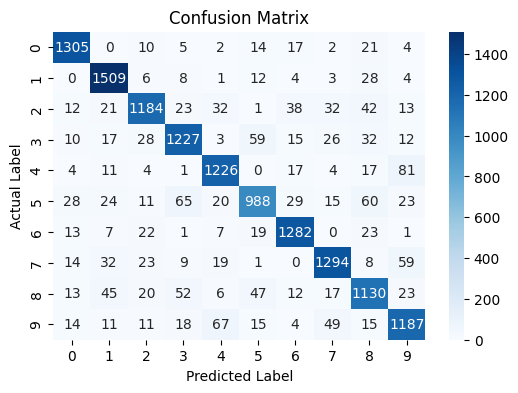


Final Test Accuracy: 91.16%


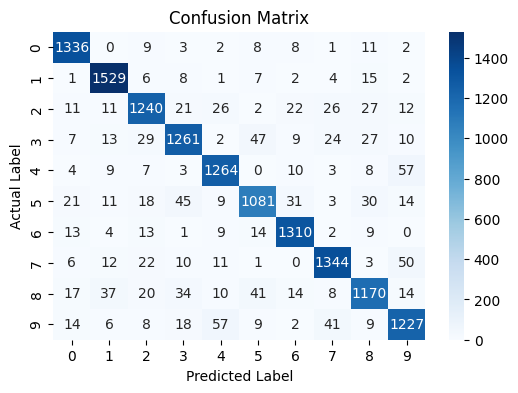


Final Test Accuracy: 92.11%


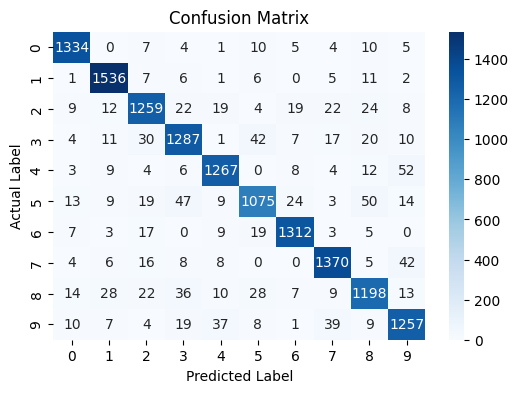


Final Test Accuracy: 84.91%


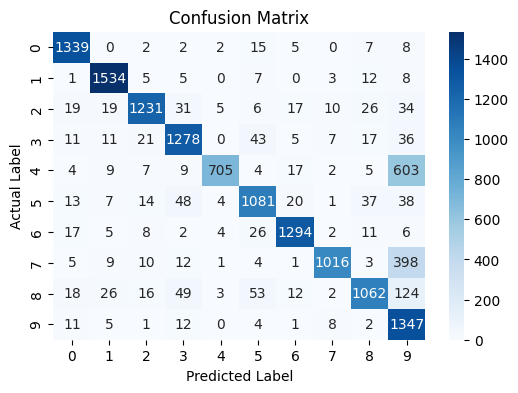

In [118]:
train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters1[1])
multi_test(w1, b1, test_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters2[1])
multi_test(w2, b2, test_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters3[1])
multi_test(w3, b3, test_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters4[1])
multi_test(w4, b4, test_dataloader)

testing batch sizes

In [119]:
hyperparameters1 = [0.01, 16, 20]
hyperparameters2 = [0.01, 32, 20]
hyperparameters3 = [0.01, 64, 20]
hyperparameters4 = [0.01, 128, 20]

Learning rate: 0.01
Batch size: 16
Epochs: 20
starting training...
Training finished.


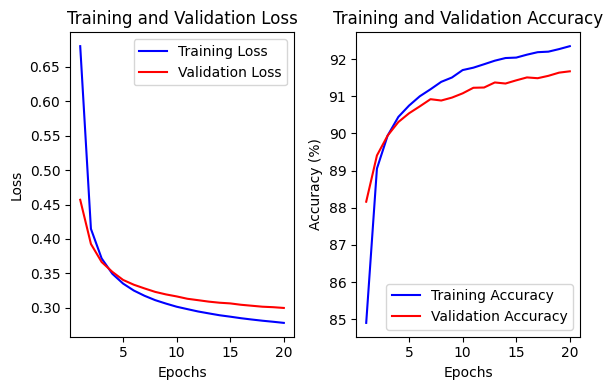

Learning rate: 0.01
Batch size: 32
Epochs: 20
starting training...
Training finished.


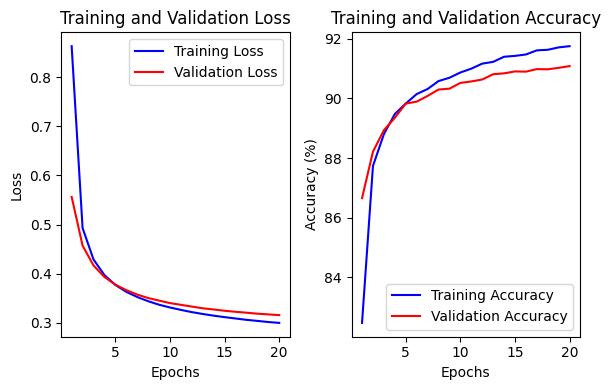

Learning rate: 0.01
Batch size: 64
Epochs: 20
starting training...
Training finished.


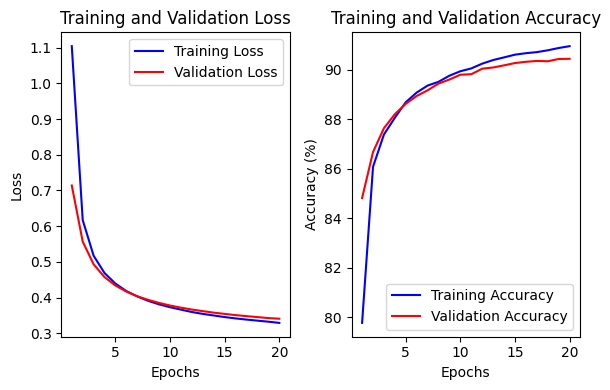

Learning rate: 0.01
Batch size: 128
Epochs: 20
starting training...
Training finished.


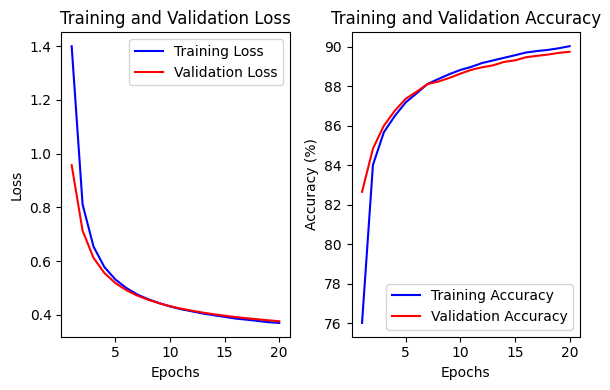

In [120]:
train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters1[1])
w1, b1 = multi_train(hyperparameters1, False, train_dataloader, val_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters2[1])
w2, b2 = multi_train(hyperparameters2, False, train_dataloader, val_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters3[1])
w3, b3 = multi_train(hyperparameters3, False, train_dataloader, val_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters4[1])
w4, b4 = multi_train(hyperparameters4, False, train_dataloader, val_dataloader)


Final Test Accuracy: 91.64%


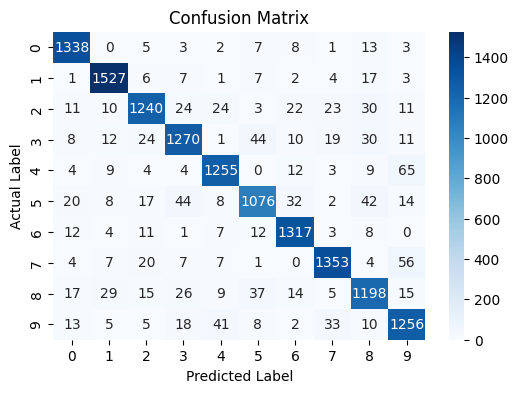


Final Test Accuracy: 91.16%


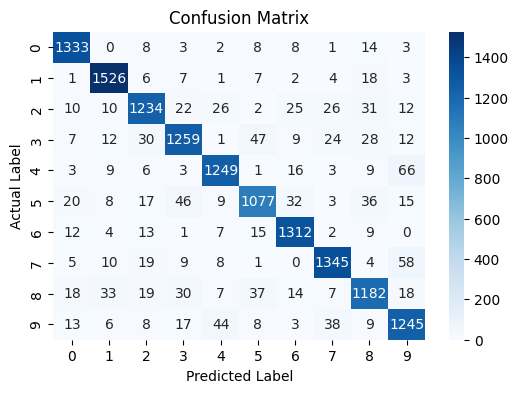


Final Test Accuracy: 90.56%


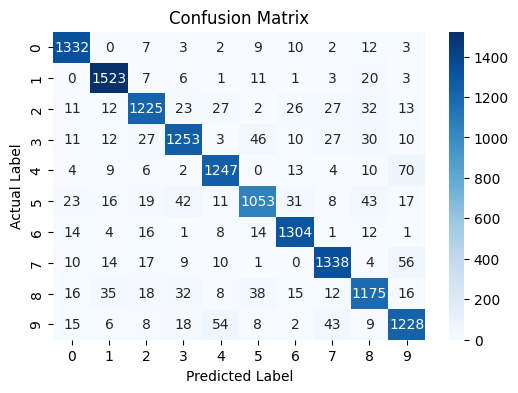


Final Test Accuracy: 89.60%


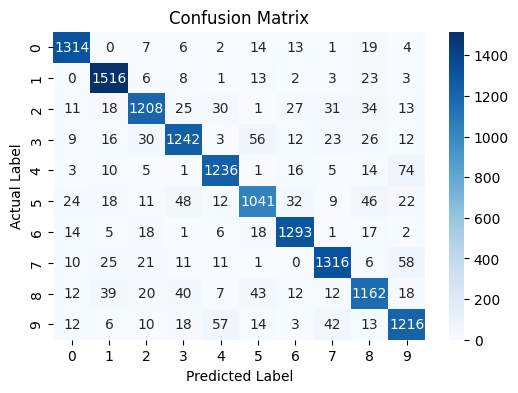

In [121]:
train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters1[1])
multi_test(w1, b1, test_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters2[1])
multi_test(w2, b2, test_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters3[1])
multi_test(w3, b3, test_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters4[1])
multi_test(w4, b4, test_dataloader)

### torch

testing learning rates

In [122]:
hyperparameters1 = [0.001, 32, 20]
hyperparameters2 = [0.01, 32, 20]
hyperparameters3 = [0.1, 32, 20]
hyperparameters4 = [1, 32, 20]

In [123]:
model_builtin1 = BuiltInSoftmaxModel()
model_builtin2 = BuiltInSoftmaxModel()
model_builtin3 = BuiltInSoftmaxModel()
model_builtin4 = BuiltInSoftmaxModel()

criterion = nn.CrossEntropyLoss()

Learning rate: 0.001
Batch size: 32
Epochs: 20
Starting built-in pytorch training for verification...
Built-in pytorch training finished.


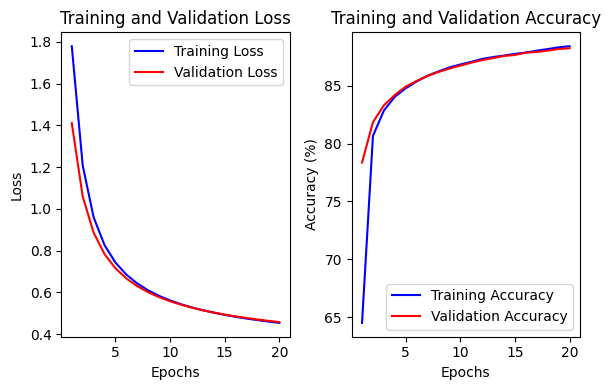

Learning rate: 0.01
Batch size: 32
Epochs: 20
Starting built-in pytorch training for verification...
Built-in pytorch training finished.


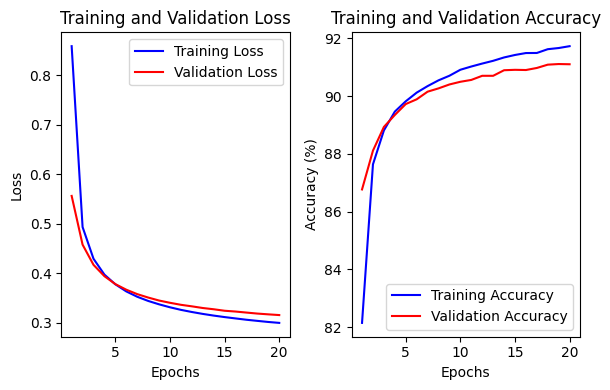

Learning rate: 0.1
Batch size: 32
Epochs: 20
Starting built-in pytorch training for verification...
Built-in pytorch training finished.


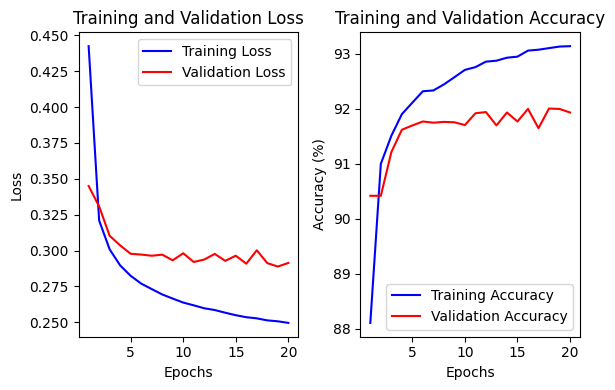

Learning rate: 1
Batch size: 32
Epochs: 20
Starting built-in pytorch training for verification...
Built-in pytorch training finished.


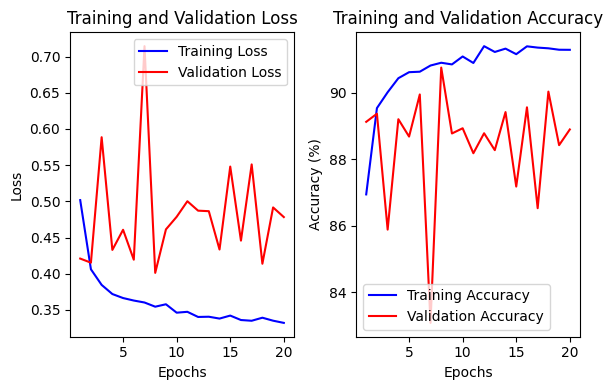

In [124]:
train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters1[1])
torch_train(model_builtin1, hyperparameters1, False, train_dataloader, val_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters2[1])
torch_train(model_builtin2, hyperparameters2, False, train_dataloader, val_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters3[1])
torch_train(model_builtin3, hyperparameters3, False, train_dataloader, val_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters4[1])
torch_train(model_builtin4, hyperparameters4, False, train_dataloader, val_dataloader)



Final Test Accuracy: 88.11%


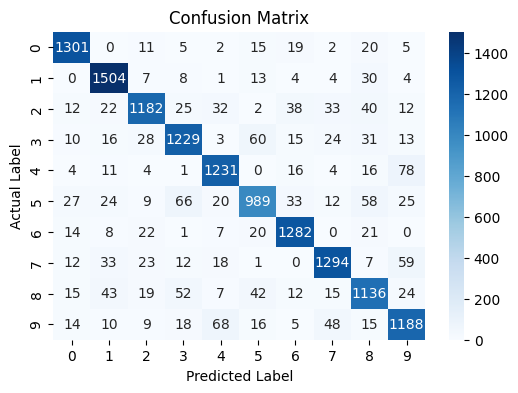


Final Test Accuracy: 91.13%


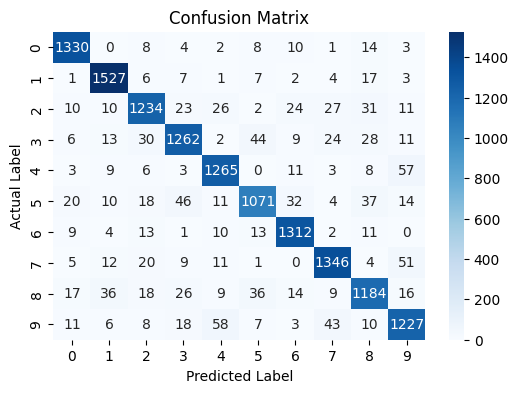


Final Test Accuracy: 92.18%


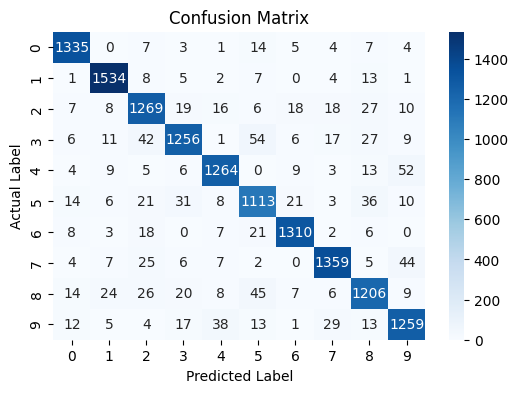


Final Test Accuracy: 88.99%


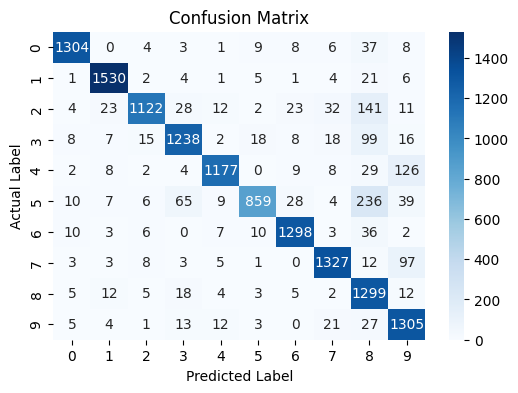

In [125]:
train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters1[1])
torch_test(model_builtin1, test_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters2[1])
torch_test(model_builtin2, test_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters3[1])
torch_test(model_builtin3, test_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters4[1])
torch_test(model_builtin4, test_dataloader)


testing batch sizes

In [126]:
model_builtin1 = BuiltInSoftmaxModel()
model_builtin2 = BuiltInSoftmaxModel()
model_builtin3 = BuiltInSoftmaxModel()
model_builtin4 = BuiltInSoftmaxModel()

criterion = nn.CrossEntropyLoss()

In [127]:
hyperparameters1 = [0.01, 16, 20]
hyperparameters2 = [0.01, 32, 20]
hyperparameters3 = [0.01, 64, 20]
hyperparameters4 = [0.01, 128, 20]

Learning rate: 0.01
Batch size: 16
Epochs: 20
Starting built-in pytorch training for verification...
Built-in pytorch training finished.


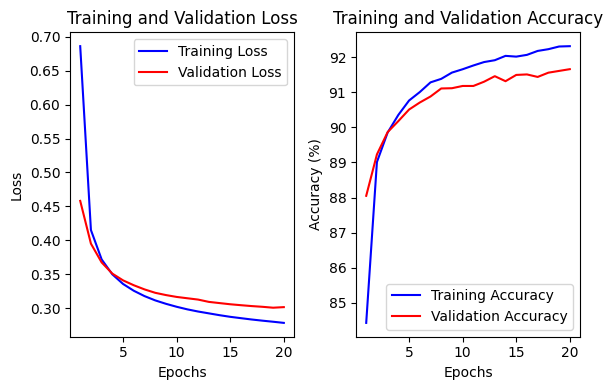

Learning rate: 0.01
Batch size: 32
Epochs: 20
Starting built-in pytorch training for verification...
Built-in pytorch training finished.


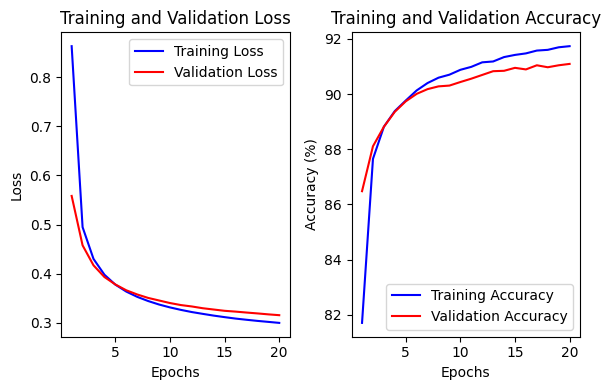

Learning rate: 0.01
Batch size: 64
Epochs: 20
Starting built-in pytorch training for verification...
Built-in pytorch training finished.


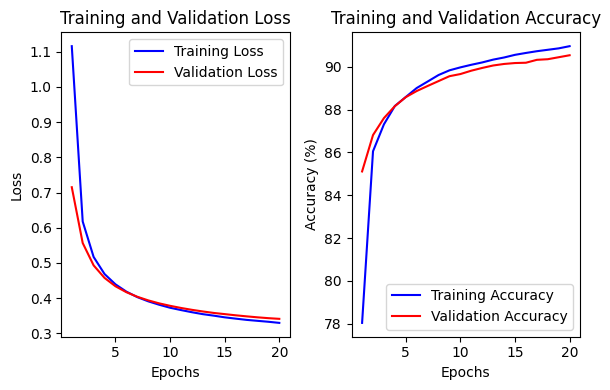

Learning rate: 0.01
Batch size: 128
Epochs: 20
Starting built-in pytorch training for verification...
Built-in pytorch training finished.


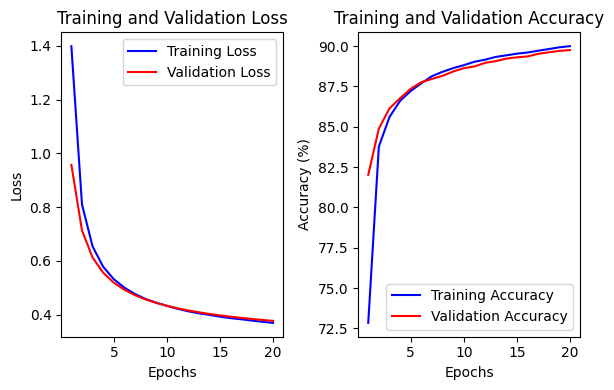

In [128]:
train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters1[1])
torch_train(model_builtin1, hyperparameters1, False, train_dataloader, val_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters2[1])
torch_train(model_builtin2, hyperparameters2, False, train_dataloader, val_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters3[1])
torch_train(model_builtin3, hyperparameters3, False, train_dataloader, val_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters4[1])
torch_train(model_builtin4, hyperparameters4, False, train_dataloader, val_dataloader)



Final Test Accuracy: 91.83%


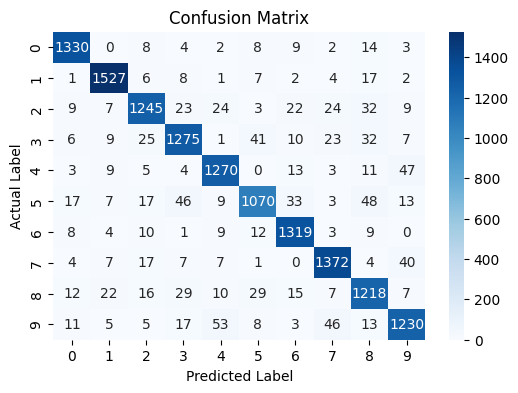


Final Test Accuracy: 91.15%


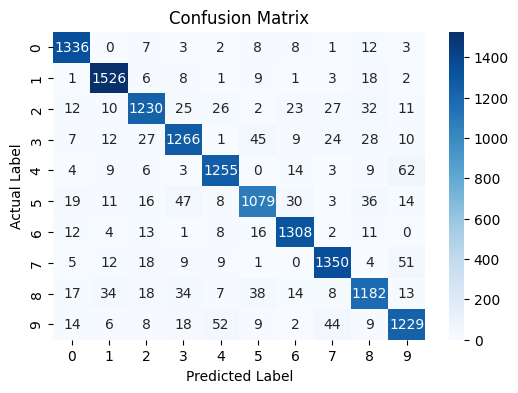


Final Test Accuracy: 90.52%


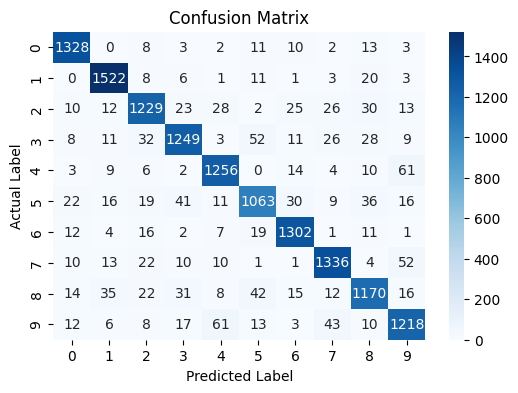


Final Test Accuracy: 89.71%


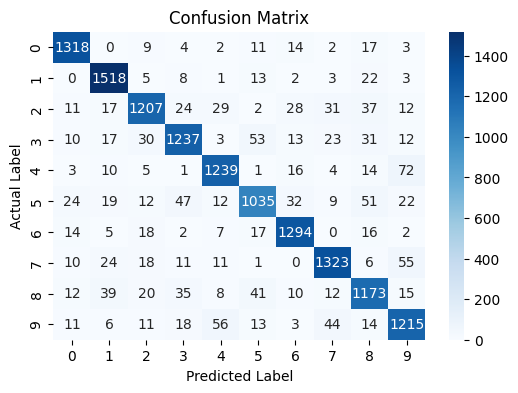

In [129]:
train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters1[1])
torch_test(model_builtin1, test_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters2[1])
torch_test(model_builtin2, test_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters3[1])
torch_test(model_builtin3, test_dataloader)

train_dataloader, val_dataloader, test_dataloader = create_tensors_loaders(x_train, y_train, x_val, y_val, x_test, y_test,
hyperparameters4[1])
torch_test(model_builtin4, test_dataloader)
